<a href="https://colab.research.google.com/github/eddes/buildingphysics/blob/feature%2Fchapter_3_notebooks/notebooks/chapter_3/auto_tuning_PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Auto tunning PID

In this example, the parameters of a PID controller are tuned using a simple optimization method. This PID controls the water level of a tank. The objectives of this optimization are :

- To fill the tank to a water level H as fast as possible
- To limit the actions on the valve in order to reduce wear and tear and maintenance

Please read the [PID controller](https://github.com/eddes/buildingphysics/blob/master/notebooks/chapter_2/PID_controller.ipynb) notebook beforehand as an introduction.


Usual dependencies imports.

In [0]:
# Some colors
rouge_A = '#C60C2E'
vert1_A = '#005157'
vert2_A = '#627D77'
vert3_A = '#9EB28F'
vert4_A = '#C5E5A4'
medblue = 'royalblue'
gris1_A = '#595A5C'
coule = [rouge_A, vert1_A, vert2_A, vert3_A, vert4_A, medblue, gris1_A]
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize


Definition of Crank-Nicolson's scheme applied to this problem. Cf equation (1.32) in the book.

In [0]:
# solve for the water height with Crank-Nicolson's scheme
def fc_CN(hp, h, dt, A, B):
    return -hp + h + 0.5 * (dt * (A - B * np.sqrt(h))) + 0.5 * (dt * (A - B * np.sqrt(hp)))

A method to model the behavior of the valve. 

In [0]:
# a function to chose the shape of the valve curve
def fc_valve_curve(characteristic, valve_pos, Qmax):
    if characteristic == "linear":
        Qsupply = Qmax * valve_pos
    elif characteristic == "equal_pct":
        Qsupply = Qmax * np.exp(3.5 * (valve_pos - 1))
    elif characteristic == "quadratic":
        Qsupply = Qmax * valve_pos ** 2
    return Qsupply

characteristic = "linear"
# characteristic="equal_pct"
# characteristics="quadratic"


Definition of geometrical data. Dimension of the tank and initial PID parameters.

In [0]:
# Geometrical data
Pi = 3.14159269  # pi
Dr = 1  # m tank diameter
Ds = 0.04  # m outlet diameter
Sr = Pi * Dr ** 2 / 4  # m2 tank surface
Ss = Pi * Ds ** 2 / 4  # m2 outlet surface
H0 = 1  # m tank height

Qmax = 15  # max flow rate L/s
Qmax = Qmax / 1000  # conversion to m3/s
f_init = 0. # Inital ratio of water in the tank. For f_init = 0, the tank is empty
# time and timestep
t = 0
dt = 0.5  # [s] time step /sampling rate
B = Ss / Sr * np.sqrt(2 * 9.81)  # precompute B, constant in the equation for h

### Main method for the simulation loop.

The objective is defined by the quantity $  \frac{\Delta t}{t_{max}} \left( \sum_{k=1}^{t_{max}} |h(t)-H| \right)^2 $, with $\Delta t$ the timestep, $t_{max}$ maximum simulation time, $h(t)$ the water height at $t$ and $H$ the water height objective. THe faster the water level reaches H (and stays), the smaller the objective quantity will be. 

To optimize this PID, the `run_pid_simulation` method simulates the PID behavior for a given parameter set. The objective quantity is computed. An additional penalty will be added if the valve is too much used to control the water level. This sum is the quantity to reduce in order to optimize the PID parameters. 

It has to be noted that each optimization step requires a full simulation to be run. Therefore the `sim_time` should remain limited to reduce computation time and focus on the early PID action. 

The tank starts empty, without an initial flow rate. 

In [0]:
def run_pid_simulation(pid_params):

    BP, Tn, Td = pid_params[0], pid_params[1], pid_params[2] # get the PID's parameters
    Kp = 1 / BP
    # initial values
    h = f_init * H0  # m height = set point height
    Qsupply = 0  # no flow rate initially
    sim_time = 200  # simulation duration s
    time, height, v_pos = [], [], []
    t = 0
    # Parameters init
    sum_error = 0
    delta_error = 0
    valve_position = 0
    deltaT_previous = 0
    while t <= sim_time:
        # Crank-Nicolson semi-implicit for water height
        A = Qsupply / Sr  # compute A
        h = fsolve(fc_CN, h, args=(h, dt, A, B))[0]
        # integral action
        sum_error = dt / Tn * (H0 - h) + sum_error
        # derivative action
        delta_error = (H0 - h) - deltaT_previous
        # computation of the valve position with PID
        valve_position = Kp * ((H0 - h) + sum_error + Td * delta_error / dt)
        # Control for valve opening
        if valve_position < 0.:
            valve_position = 0
            Qsupply = 0
        elif valve_position > 1:
            valve_position = 1
            Qsupply = Qmax
        else:
            Qsupply = fc_valve_curve(characteristic, valve_position, Qmax)
        deltaT_previous = H0 - h
        t += dt
        time.append(t)
        height.append(h)
        v_pos.append(valve_position)
    v_pos = np.asarray(v_pos)
    
    # Computation of objective
    height_set = H0 * np.ones(len(height))
    diff = np.asarray(height) - height_set
    diff = abs(diff)
    mean_diff = np.mean(diff)

    return mean_diff, time, height, v_pos


### Loss function 
In addition to the objective quantity, a penalty is added to reduce the valve usage. This sum, also called `loss` is the quantity to be minimized. 

- The number of occurences the valve was shut during the simulation is counted. If this number is above a given threshold, a penalty is applied.

- The second part of the simulation is considered to focus on the PID behavior when the water height H is reached. For each step, the average difference of valve position between two timesteps `|v_pos[i] - v_pos[i+1|` is computed. This quantity is reduced if the valve position variations (e.g oscillations) are reduced. 

**Nota**  Modifying the penalty values in the `compute_loss` method is an interesting experiment to see the associated effects on the optimization process.
- What if the penalty is increased, reduced, negative ?


In [0]:
def compute_loss(mean_diff,height, v_pos):
    # penalize the result if the valve is closed (wear)
    penalty = 0
    idx0 = np.where(v_pos == 0)
    if len(idx0[0]) > 10:
        penalty += 100
        

    # let's consider only the 2nd half of the valve positions
    # (a steep gradient when filling the tank is expected,
    # however it is not desirable at the end of the simulation,
    # when the set value is reached)
    i=int(len(v_pos)/2) #
    # valve position at t
    v=v_pos[i:-2]
    # valve position at t+1
    vp=v_pos[i+1:-1]
    # proxy for the mean gradient
    average_gradient=np.mean(abs(vp-v))
    # if the gradient is too steep: penalisation
    if average_gradient>0.02:
        penalty+=100
    # compute gradient

    return mean_diff + penalty

def fc_to_minimize_wloss(x):
    mean_diff, _, height, v_pos = run_pid_simulation(x)
    return compute_loss(mean_diff,height,v_pos)

The inital PID parameters are set and one simulation is run as reference.

In [0]:
# bounds of the parameters
#       prop.band , integration & derivation times
bnds = ((0.1, 0.6), (5, 500) , (0.5, 100))

k = 0.5 # starting point between the bounds for each parameter
x0 = [k * (bnds[0][0] + bnds[0][1]),
      k * (bnds[1][0] + bnds[1][1]),
      k * (bnds[2][0] + bnds[2][1])]

# Initial results of the PID, without any optimization performed.
objective_0, time_0, height_0, v_pos_0 = run_pid_simulation(x0)

The optimization is performed here using a [Truncated Newton method](https://en.wikipedia.org/wiki/Truncated_Newton_method). For each step, `fc_to_minize` runs a simulation and calculate the loss function. `x0` is the initial PID parameter set. `bounds` are the value range allowed for these parameters. 

In [8]:
sol = minimize(fc_to_minimize_wloss, x0, bounds=bnds, method='TNC', tol=1e-3)

# let us plot the result
BP, Tn, Td = sol.x[0], sol.x[1], sol.x[2]
objective, time, height, v_pos = run_pid_simulation([BP, Tn, Td])

print("BP =", round(BP, 3))
print("Tn =", round(Tn, 1))
print("Td =", round(Td, 1))
print("fc obj =", round(objective, 3))

time = np.asarray(time)
time = time - dt


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


BP = 0.181
Tn = 500.0
Td = 0.5
fc obj = 0.169


Plot of the water level evolution, using the initial PID, using the optimized PID. If `sim_time` is increased in the `run_pid_simulation` method, the oscillation of the initial_PID become visible.

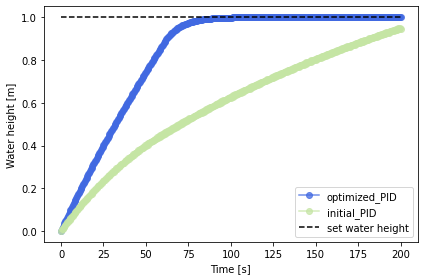

In [9]:
plt.xlabel("Time [s]")
plt.ylabel("Water height [m]")
plt.plot(time, height, color=coule[-2], linestyle="-", alpha=0.75, marker='o', label='optimized_PID')
plt.plot(time, height_0, color=coule[-3], linestyle="-", alpha=0.75, marker='o', label='initial_PID')
plt.plot(time, np.ones(len(time)) * H0, color='black', linestyle="--", alpha=0.9985, marker='',label='set water height')

plt.legend()
plt.tight_layout()
plt.show()

### Optimization visualisation
Let's modify slightly the `fc_to_minimize_wloss` method to extract the loss values over time, as well as the PID parameters. 


In [0]:
objective = [] # Log the mean_diff quantity
penalty = [] # Log the penaly quantity
BP_ = [] # Log BP values
Tn_ = [] # Log Tn values
Td_ = [] # Log Td values

def fc_to_minimize_wloss(x):
    mean_diff, _, height, v_pos = run_pid_simulation(x)
    objective.append(mean_diff)
    BP_.append(x[0])
    Tn_.append(x[1])
    Td_.append(x[2])

    loss = compute_loss(mean_diff,height,v_pos)
    penalty.append(loss - mean_diff)
    return loss

The simulation is then run again.

In [11]:
objective = [] 
penalty = [] 
BP_ = [] 
Tn_ = [] 
Td_ = [] 

sol = minimize(fc_to_minimize_wloss, x0, bounds=bnds, method='TNC', tol=1e-3)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


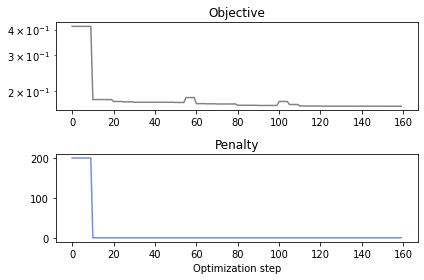

In [12]:
x_range = range(0,len(objective))
fig,ax = plt.subplots(2)
plt.xlabel("Optimization step")
ax[0].set_title("Objective")
ax[0].set_yscale('log')
ax[0].plot(x_range, objective, color=coule[-1], linestyle="-", alpha=0.75)
ax[1].set_title("Penalty")
ax[1].plot(x_range, penalty, color=coule[-2], linestyle="-", alpha=0.75)


plt.tight_layout()
plt.show()

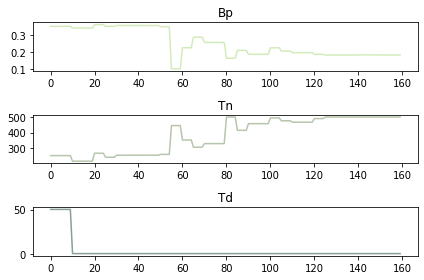

In [13]:
fig,ax = plt.subplots(3)
ax[0].set_title("Bp")
ax[0].plot(x_range, BP_, color=coule[-3], linestyle="-", alpha=0.75,  label='Bp')
ax[1].plot(x_range, Tn_, color=coule[-4], linestyle="-", alpha=0.75, label='Tn')
ax[1].set_title("Tn")

ax[2].plot(x_range, Td_, color=coule[-5], linestyle="-", alpha=0.75, label='Td')
ax[2].set_title("Td")
plt.tight_layout()
plt.show()

It is interesting to see that the `loss` drops sharply along the differential component `Td`of the PID. The integral part of the PID `Tn`is being maximized by the optimisation.